In [1]:
import pandas as pd
import numpy as np
import re
import os
from copy import copy
from os.path import join
from gtfparse import read_gtf
import csv
import pickle as pkl
from pprint import pprint
from BCBio.GFF import GFFExaminer
from utils.gtf_io import my_gtf_read,my_gtf_write,CategorizedGTF
from utils.isoform_classes import genePredReader, genePredRecord, reference_genePred_TSS_TTS_parser
from utils.transcriptomic_features.shared_classes import \
    SharedTTS, SharedTSS, SharedExon, SharedJunction, SharedSpliceSite, SharedTranscriptStructure
from utils.transcriptomic_features.ref_classes import RefTranscriptIsoform
from utils.transcriptomic_features.parse_transcriptomic_features import reference_genePred_parser
from utils.isoform_analysis import ReferenceSharedFeatureCollection,GffCompareMergedTranscripts,SupportInfo
from collections import defaultdict
from copy import copy
from bx.intervals import Interval, IntervalTree
from matplotlib_venn import venn3_unweighted,venn3
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
from utils.file_utils import read_bed,write_bed
import pyfaidx
from utils.transcriptomic_features.ref_classes import TranscriptIsoformWithSeq
from Bio.Seq import Seq
from Bio import SeqIO
import seaborn as sns
from scipy.stats import mannwhitneyu
import scipy.sparse as sp
import anndata as ad
from sklearn.preprocessing import normalize
from scipy.stats import zscore
import qnorm
sns.set_style("white")

COLOR = 'black'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['axes.edgecolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR
mpl.rcParams['axes.edgecolor'] = COLOR
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['pdf.fonttype'] = 'truetype'
%load_ext autoreload
%autoreload 2
%load_ext jupyter_spaces

In [2]:
def normalize_expression_table(table,log=False,quantile=False,z_score=False,clip=False):
    if log:
        table=np.log1p(table)
    if quantile:
        table=qnorm.quantile_normalize(table,axis=1,ncpus=15)
    if z_score:
        table=table.apply(zscore,axis=1)
    if clip:
        table=table.clip(-3,3)
    return table

In [3]:
tcga_coad_isoform_level=pd.read_csv("PacBio/TCGA/TCGA-COAD.expression/TCGA-COAD.TPM.expression.full",sep="\t")
tcga_coad_isoform_level_normalized=normalize_expression_table(
    tcga_coad_isoform_level,
    log=True,
    quantile=True,
    z_score=False
)

In [4]:
ms_table=pd.read_csv("PacBio/downstream/combined/MS_proteomics/filtered.colon.cancer.novel.ms.peptide.v2.new.txt",sep="\t")
# ms_table=pd.read_excel("PacBio/downstream/combined/MS_proteomics/colo.cancer.putative.EpiT.specific.mspep.v2.new.xlsx")
ms_supported_isoforms_dict=defaultdict(set)
for row in ms_table.itertuples():
    for iso in row.reference.split(','):
        if iso in tcga_coad_isoform_level.index:
            ms_supported_isoforms_dict[iso].add(row.peptide)
ms_supported_isoforms_dict=dict(ms_supported_isoforms_dict)
ms_supported_isoforms=list(ms_supported_isoforms_dict.keys())

In [5]:
def aggregate_per_patient_expression_table(table):
    tumor_samples=[col for col in table.columns if col.split('-')[3] < '10']
    normal_samples=[col for col in table.columns if col.split('-')[3] >= '10']
    patient_ids=pd.Series(
        data=['-'.join(col.split('-')[:3]) for col in table.columns],
        index=table.columns
    )
    patient_ids_df=pd.DataFrame({"patient_ids":patient_ids})
    print("# tumor samples:",len(tumor_samples))
    print("# normal samples:",len(normal_samples))
    print("# patients:",patient_ids.nunique())
    print("# patients with tumor sample:",patient_ids[tumor_samples].nunique())
    print("# patients with normal sample:",patient_ids[normal_samples].nunique())
    
    agg_expression_table_list=list()
    for patient_id,group in patient_ids_df.loc[normal_samples].groupby("patient_ids"):
        expression_agg_series=table.loc[:,group.index].mean(axis=1)
        expression_agg_series.name=patient_id+'-N'
        agg_expression_table_list.append(expression_agg_series)
    
    for patient_id,group in patient_ids_df.loc[tumor_samples].groupby("patient_ids"):
        expression_agg_series=table.loc[:,group.index].mean(axis=1)
        expression_agg_series.name=patient_id+'-T'
        agg_expression_table_list.append(expression_agg_series)
        
    return pd.concat(agg_expression_table_list,axis=1)
tcga_coad_isoform_level_patient_agg=aggregate_per_patient_expression_table(tcga_coad_isoform_level_normalized)

# tumor samples: 483
# normal samples: 41
# patients: 458
# patients with tumor sample: 458
# patients with normal sample: 41


In [127]:
def rename_HLA_allele_netMHCpan(al):
    HLA_gene, subtype = al.split('*')
    netMHCpan_format='HLA-%s%s'%(HLA_gene,subtype)
    return netMHCpan_format
def process_TCGA_HLA_call(table):
    table=table.copy()
    HLA_columns=["A1","A2","B1","B2","C1","C2"]
    for col in HLA_columns:
        table[col]=table[col].map(rename_HLA_allele_netMHCpan)
    table["patient_id"]=table["aliquot_id"].map(lambda x: '-'.join(x.split('-')[:3]))
    return table
if False:
    TCGA_HLA_call=pd.read_csv("PacBio/HLA/HLA_calls/OptiTypeCallsHLA_bams_20170323.tsv",sep=",")
    process_TCGA_HLA_call(TCGA_HLA_call).set_index("patient_id").to_csv("PacBio/HLA/TCGA_HLA_calls/OptiTypeCallsHLA_bams_20170323.converted.tsv")
else:
    TCGA_HLA_call=pd.read_csv("PacBio/HLA/HLA_calls/OptiTypeCallsHLA_bams_20170323.converted.tsv",index_col=0)
    in_house_HLA_call=pd.read_csv("PacBio/HLA/HLA_calls/in-house.HLA_calls.csv",sep=",",index_col=0)

In [7]:
def process_simplified_table(table):
    epi_types=["Epi_normal","Epi_tumor","Epi_not_determined"]
    other_types=[
        'Fibro', 'Granulo',
        'ILC', 'Macro',
        'Mast', 'Mono',
        'Myeloid_not_determined',
        'NK', 'Plasma',
        'TCD4', 'TCD8',
        'TNKILC_not_determined',
        'TZBTB16',
        'Tgd', '_PB_CB_not_found_in_IL'
    ]
    
    table["Epi_types_summary_CB"]=0
    table["Epi_types_summary_CB_Total"]=0
    for ty in epi_types:
        table["Epi_types_summary_CB"]+=table[ty+"_CB"]
        table["Epi_types_summary_CB_Total"]+=table[ty+"_CB_Total"]
    
    table["other_types_summary_CB"]=0
    table["other_types_summary_CB_Total"]=0
    for ty in other_types:
        table["other_types_summary_CB"]+=table[ty+"_CB"]
        table["other_types_summary_CB_Total"]+=table[ty+"_CB_Total"]
    
    return table

simplified_isoform_table=pd.read_csv("PacBio/downstream/combined/simplified_isoform_level-PacBio-gffcmp-clusterfull.unfiltered.2.csv")
simplified_gene_table=pd.read_csv("PacBio/downstream/combined/simplified_gene_level-PacBio-gffcmp-clusterfull.unfiltered.csv")

simplified_isoform_table=process_simplified_table(simplified_isoform_table)
simplified_gene_table=process_simplified_table(simplified_gene_table)

def collate_gene_level_barcodes(isoform_table,gene_table):
    isoform_table=pd.merge(isoform_table,gene_table[["GeneSymbol","NSupportingPB_CB"]],on="GeneSymbol",how="left",suffixes=["","_gene_level"])
    isoform_table["PercEpiTSupportingPB_CB"]=isoform_table["Epi_tumor_CB"]/isoform_table["NSupportingPB_CB_gene_level"]
    return isoform_table

simplified_isoform_table=collate_gene_level_barcodes(simplified_isoform_table,simplified_gene_table)

In [8]:
def isoform_and_kmer_selection1(simplified_isoform_table,kmer_table,ms_supported_isoforms):
    isoform_table=simplified_isoform_table.set_index("Isoform").loc[ms_supported_isoforms].reset_index()
#     isoform_table=simplified_isoform_table
    isoform_table=isoform_table\
        .query("(Epi_tumor_CB>=1) & (Epi_normal_CB==0) & (other_types_summary_CB==0) & (SupportingStructCategory in ['novel_in_catalog','novel_not_in_catalog'])")\
        .sort_values(by="Epi_tumor_CB",ascending=False)

    print(isoform_table.shape[0])
    isoform_table=isoform_table\
        .query("(SupportingStructCategory in ['novel_in_catalog','novel_not_in_catalog'])")\
        .sort_values(by="Epi_tumor_CB",ascending=False)
    
    selected_isoforms_inhouse=set(isoform_table["Isoform"].tolist())

    print("# isoforms has high percentage of in-house tumor expression:",len(selected_isoforms_inhouse))
    
    kmer_table=kmer_table\
        .query("(Epi_tumor_CB>0) & (Epi_normal_CB==0) & (other_types_summary_CB==0) & ('novel_not_in_catalog' in structural_category | 'novel_in_catalog' in structural_category)")
    selected_isoforms_by_kmer=set()
    for isoforms in kmer_table["isoforms"]:
        selected_isoforms_by_kmer.update(isoforms.split(','))
    
    print("# allowed kmers:",kmer_table.shape[0])
    print("# isoforms has allowed kmers:",len(selected_isoforms_by_kmer))
    
    selected_isoforms=selected_isoforms_inhouse&selected_isoforms_by_kmer
    
    selected_isoforms_ms=[
        'TCONS_00078414',
        'TCONS_00079116',
        'TCONS_00042919',
        'TCONS_00044960',
        'TCONS_00042881',
        'TCONS_00100482',
        'TCONS_00109177',
        'TCONS_00113091',
    ]

    selected_isoforms_noms=[
        'TCONS_00041997',
        'TCONS_00045160',
        'TCONS_00052349',
        'TCONS_00112393'
    ]
    
    selected_isoforms_disregard_ms=[
        'TCONS_00044960', 'TCONS_00113091', 'TCONS_00052315', 
        'TCONS_00030680', 'TCONS_00093518', 'TCONS_00038926',
        'TCONS_00084297', 'TCONS_00106659', 'TCONS_00100482',
        'TCONS_00042881', 'TCONS_00116685', 'TCONS_00077455',
#         'TCONS_00079116', 'TCONS_00032404'
    ]
    
#     selected_isoforms=selected_isoforms_disregard_ms
    print("# isoforms:",len(selected_isoforms))
    isoform_table=isoform_table.loc[isoform_table["Isoform"].isin(selected_isoforms),:]
    kmer_table=kmer_table.loc[kmer_table["isoforms"].map(lambda x: any(i in selected_isoforms for i in x.split(',')))]
    
    return isoform_table,kmer_table

kmer_table=pd.read_csv("PacBio/HLA/kmer.observed.novel.diff_stats.csv")
isoform_table_selection1,kmer_table_selection1=isoform_and_kmer_selection1(
    simplified_isoform_table,kmer_table,ms_supported_isoforms
)

258
# isoforms has high percentage of in-house tumor expression: 258
# allowed kmers: 128454
# isoforms has allowed kmers: 5287
# isoforms: 193


In [9]:
kmer_HLA_table=pd.read_hdf("PacBio/HLA/collections/9mers.observed.ES_rank.h5")

In [17]:
def transcript_TCGA_expression_stats(expr_table,isoform_list=None):
    tumor_samples=[col for col in expr_table.columns if col.split('-')[3] < '10']
    normal_samples=[col for col in expr_table.columns if col.split('-')[3] >= '10']
    print("# tumor samples:",len(tumor_samples))
    print("# normal samples:",len(normal_samples))
    if isoform_list is not None:
        expr_table=expr_table.loc[isoform_list,:]
    tumor_threshold=1
    normal_threshold=1
    stats_df=pd.DataFrame(
        {
            'tumor_avg_exp':expr_table.loc[:,tumor_samples].mean(axis=1),
            'normal_avg_exp':expr_table.loc[:,normal_samples].mean(axis=1),
            'tumor_expressed_avg_exp':expr_table.loc[:,tumor_samples].apply(lambda x: x[x>0].mean(),axis=1),
            'n_tumor_samples':(expr_table.loc[:,tumor_samples]>tumor_threshold).sum(axis=1),
            'n_normal_samples':(expr_table.loc[:,normal_samples]>normal_threshold).sum(axis=1)
        }
    )
    
    stats_df["n_samples_difference"]=stats_df["n_tumor_samples"]-stats_df["n_normal_samples"]
    return stats_df

stats_df=transcript_TCGA_expression_stats(tcga_coad_isoform_level,isoform_list=list(selected_isoforms_ms+selected_isoforms_noms))

# tumor samples: 483
# normal samples: 41


In [18]:
def isoform_and_kmer_selection2(isoform_table,kmer_table,TCGA_stats_df,kmer_HLA_table):
    print("isoform_table:",isoform_table.shape[0])
    print("kmer_table:",kmer_table.shape[0])
    
    HLA_weights={k:1 for k in kmer_HLA_table.columns}
    isoform_list=TCGA_stats_df.query("n_tumor_samples>=5 & n_normal_samples==0").sort_values(["tumor_expressed_avg_exp"],ascending=False).index.tolist()
    isoform_list=[iso for iso in isoform_list if iso in isoform_table["Isoform"].values]
    print("#isoforms passing TCGA requirments:",len(isoform_list))
    kmers_by_transcripts=dict()
    for iso in isoform_list:
        kmers=kmer_table.query("isoforms.str.contains('{}')".format(iso),engine='python')["kmer"].tolist()
        kmers_by_transcripts[iso]=set(kmers)
        
    all_kmers=set()
    for kmers in kmers_by_transcripts.values():
        all_kmers.update(kmers)
    kmer_binding_sets=dict()
    binding_threshold=2
    for kmer in all_kmers:
        kmer_binding_sets[kmer]=set(kmer_HLA_table.columns[kmer_HLA_table.loc[kmer,:]<binding_threshold])
        
    return kmers_by_transcripts,HLA_weights,kmer_binding_sets
top50_HLA_list=pd.read_csv("PacBio/HLA/allele_frequency/top50.csv",header=None)[0].tolist()
kmers_by_transcripts_selection2,HLA_weights_selection2,kmer_binding_sets_selection2=isoform_and_kmer_selection2(
    isoform_table_selection1,
    kmer_table_selection1,
    stats_df,
    kmer_HLA_table.loc[:,top50_HLA_list]
)

isoform_table: 193
kmer_table: 9605
#isoforms passing TCGA requirments: 12


0.7991266375545851


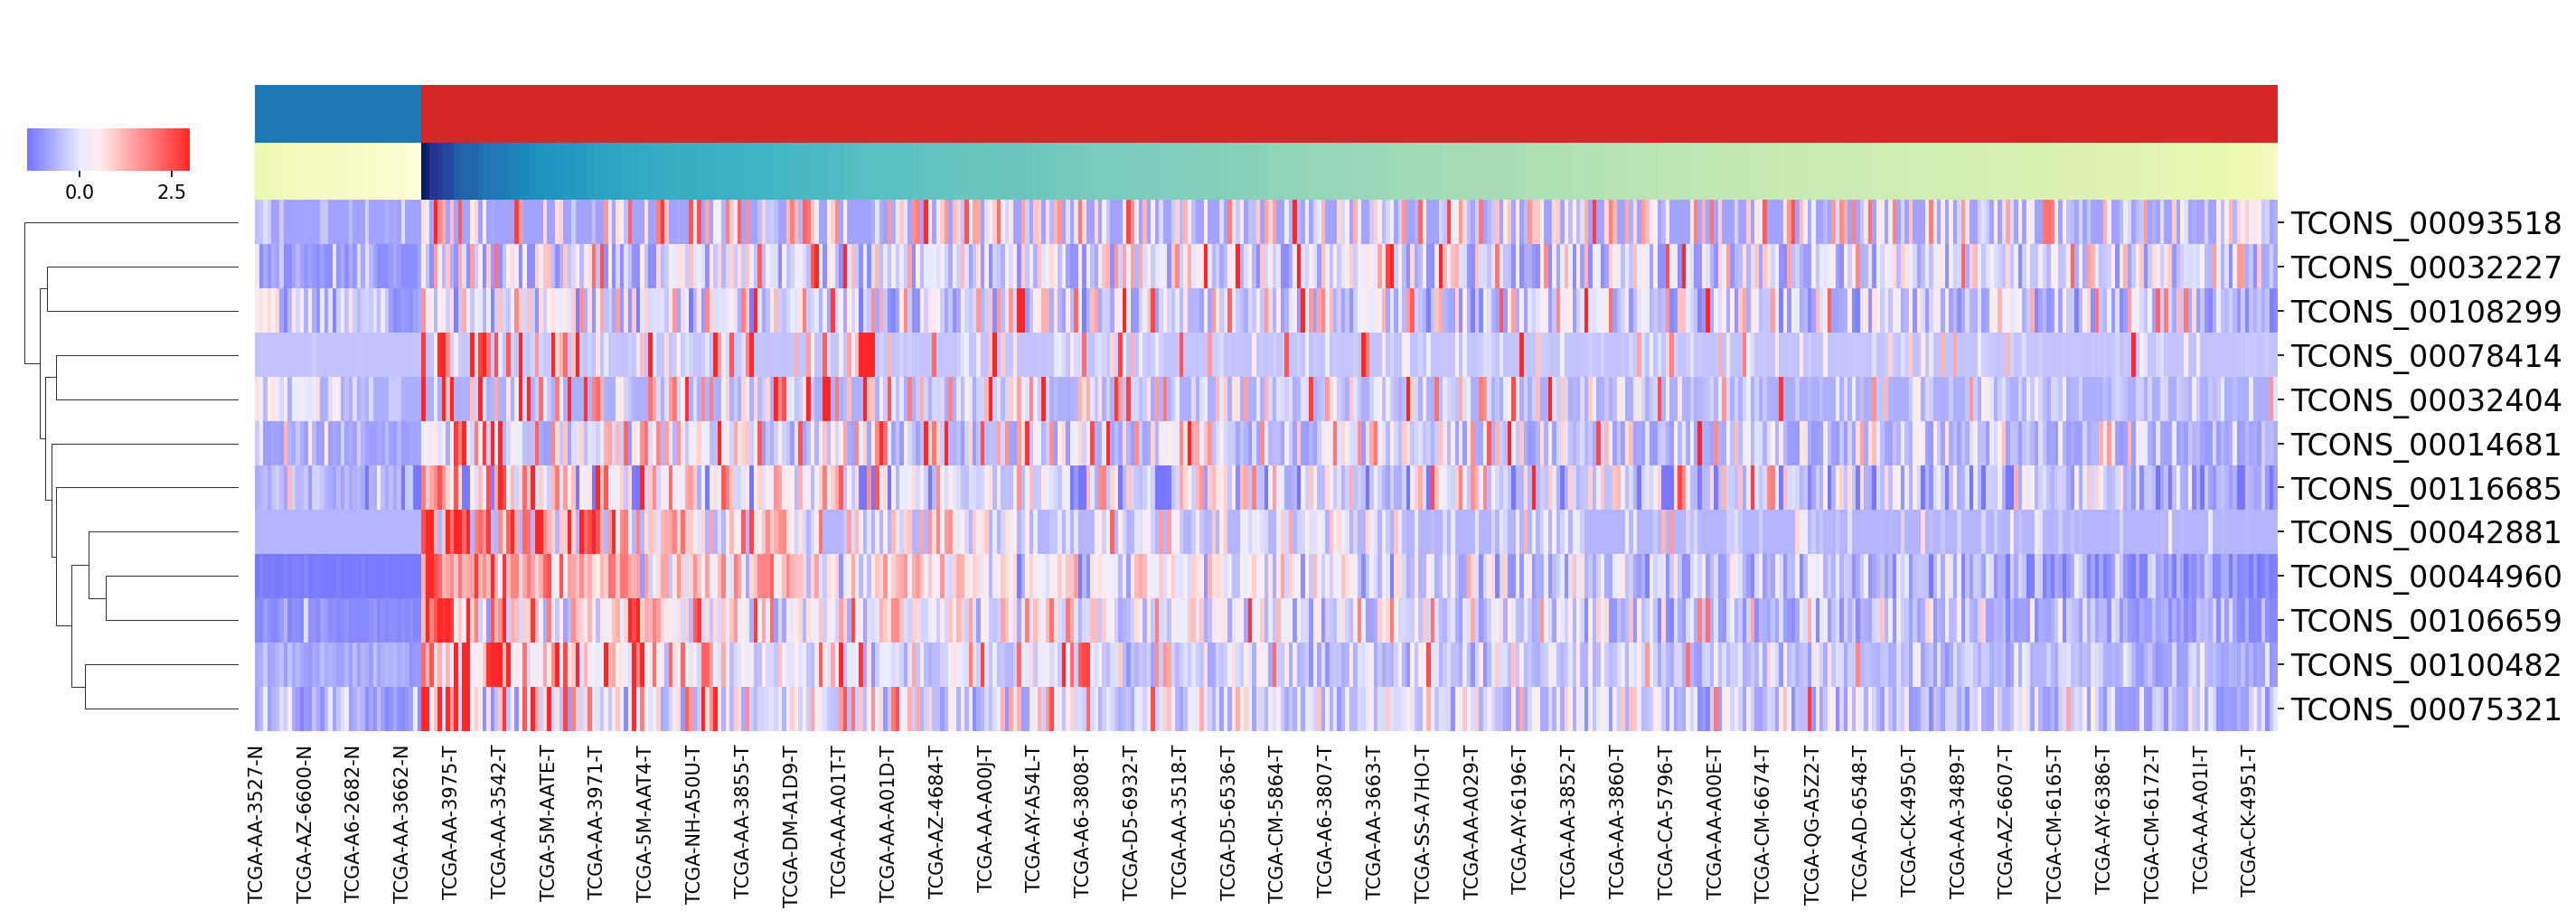

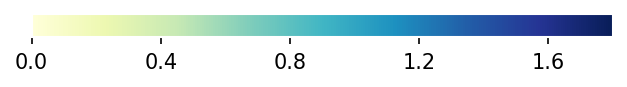

In [19]:
from scipy.spatial import distance
from scipy.cluster.hierarchy import fcluster,linkage,leaves_list

def plot_isoform_expression(
    isoform_expression_table,transcript_list,
    row_cluster=False,col_cluster=False,
    row_labels=None,col_labels=None,
    row_values=None,col_values=None,
    row_linkage=None,col_linkage=None,
    z_score=False,show_max=True
):
    min_height=0.3
    height_per_transcript=0.5
    figure_height=min_height+len(transcript_list)*height_per_transcript
    col_cmap=[sns.color_palette("tab10")[i] for i in [0,3,1,2,4,5,6,7,8,9]]
    # process_table
    plot_df=isoform_expression_table.loc[transcript_list,:]
    
    if z_score:
        plot_df=plot_df.apply(zscore,axis=1)
        plot_df=plot_df.clip(-3,3)
    if show_max:
        plot_df.loc["MAX",:]=plot_df.max(axis=0)
    plot_df=plot_df.astype(np.float32)
    
    row_colors=list()
    col_colors=list()
    # row_labels
    if row_labels is not None:
        row_palette=dict(zip(sorted(row_labels.unique()),sns.color_palette("muted")))
        row_colors.append([row_palette[i] for i in row_labels.values])

    
    # col_labels
    if col_labels is not None:
        col_palette=dict(zip(sorted(col_labels.unique()),col_cmap))
        col_colors.append([col_palette[i] for i in col_labels.values])

    
    if row_values is not None:
        row_cmap=plt.get_cmap("bwr")
        row_colors.append([row_cmap(i) for i in row_values.values])
    
    if col_values is not None:
        col_cmap=plt.get_cmap("YlGnBu")
        col_colors.append([col_cmap(i) for i in col_values.values])
    
    if len(row_colors)==0:
        row_colors=None
        
    if len(col_colors)==0:
        col_colors=None
        
    if row_labels is not None:
        plot_df=plot_df.loc[row_labels.index,]
        
    if col_labels is not None:
        plot_df=plot_df.loc[:,col_labels.index]
    
    # plot
    heatmap_cmap=mpl.colors.LinearSegmentedColormap.from_list(
        'pos_cmap',
        sns.color_palette('bwr',n_colors=12)[2:]
    )
    
    cg=sns.clustermap(
        plot_df,
        row_cluster=row_cluster,
        col_cluster=col_cluster,
        cmap=heatmap_cmap,
        dendrogram_ratio=0.1,
        colors_ratio=0.08,
        row_colors=row_colors,
        col_colors=col_colors,
        row_linkage=row_linkage,
        col_linkage=col_linkage,
        cbar_kws={"orientation":"horizontal"},
        cbar_pos=(0.02, 0.8, 0.06, 0.05)
    )
    
    # PP figure
    cg.ax_heatmap.set_yticklabels(cg.ax_heatmap.get_yticklabels(),rotation=0,fontsize=16)

#     cg.ax_cbar.set_visible(False)
    _=cg.ax_heatmap.set_ylabel(None)
    _=cg.ax_heatmap.set_xlabel(None)
    plt.gcf().set_size_inches((20,figure_height))

col_labels=pd.Series(
    data=tcga_coad_isoform_level_patient_agg.columns.map(lambda x: 'tumor' if x.split('-')[3]=='T' else 'normal'),
    index=tcga_coad_isoform_level_patient_agg.columns
)

selected_isoforms_default=list(kmers_by_transcripts_selection2.keys())
selected_isoforms_ms_EpiT=[
    "TCONS_00068105",
    "TCONS_00078414",
    "TCONS_00032227",
    "TCONS_00079116",
    "TCONS_00109177",
    "TCONS_00041997",
]

selected_isoforms_non_NMD=[
#     "TCONS_00068105",
    "TCONS_00078414",
#     "TCONS_00032227",
    "TCONS_00079116",
    "TCONS_00109177",
    "TCONS_00041997",
]

selected_isoforms_NMD=[
    "TCONS_00044960",
    "TCONS_00042881",
    "TCONS_00113091",
    "TCONS_00100482",
    "TCONS_00112393",
    "TCONS_00042919",
    "TCONS_00052349",
    "TCONS_00045160"
]

selected_isoforms_ms=[
    'TCONS_00078414',
    'TCONS_00079116',
    'TCONS_00042919',
    'TCONS_00044960',
    'TCONS_00042881',
    'TCONS_00100482',
    'TCONS_00109177',
    'TCONS_00113091',
]

selected_isoforms_noms=[
    'TCONS_00041997',
    'TCONS_00045160',
    'TCONS_00052349',
    'TCONS_00112393'
]

selected_isoforms_disregard_ms=[
    'TCONS_00032227',
    'TCONS_00093518',
    'TCONS_00044960',
    'TCONS_00014681',
    'TCONS_00078414',
    'TCONS_00100482',
    'TCONS_00108299',
    'TCONS_00106659',
    'TCONS_00116685',
    'TCONS_00042881',
    'TCONS_00032404',
    'TCONS_00075321'
]

def sort_columns(df,col_labels):
    if False:
        normal_cols=col_labels.index[col_labels=='normal']
        normal_cols=df.loc[:,normal_cols].sort_values(by=list(df.index),ascending=False,axis=1).columns

        tumor_cols=col_labels.index[col_labels=='tumor']
        tumor_cols=df.loc[:,tumor_cols].sort_values(by=list(df.index),ascending=False,axis=1).columns
        
    df_mean=df.mean(axis=0).sort_values(ascending=False)
    normal_cols=df_mean.index[df_mean.index.str.endswith("-N")]
    tumor_cols=df_mean.index[df_mean.index.str.endswith("-T")]
    df_mean_min_max=(df_mean-df_mean.min())/(df_mean.max()-df_mean.min())
    norm = mpl.colors.Normalize(vmin=0, vmax=1.8)
    return df_mean_min_max,list(normal_cols)+list(tumor_cols),norm
    
def sort_columns2(df,col_labels):    
    df_mean=(df>1).sum(axis=0).sort_values(ascending=False)
    normal_cols=df_mean.index[df_mean.index.str.endswith("-N")]
    tumor_cols=df_mean.index[df_mean.index.str.endswith("-T")]
    df_mean_min_max=(df_mean-df_mean.min())/(df_mean.max()-df_mean.min())
    return df_mean_min_max,list(normal_cols)+list(tumor_cols)

# selected_isoforms=selected_isoforms_ms+selected_isoforms_noms
selected_isoforms=selected_isoforms_disregard_ms

threshold_expr=tcga_coad_isoform_level_patient_agg.loc[selected_isoforms,:]
col_values,col_order,norm=sort_columns(threshold_expr,col_labels)
# threshold_expr=threshold_expr.loc[:,col_order]
# col_labels=col_labels[col_order]
print((threshold_expr.loc[:,threshold_expr.columns.str.endswith("-T")]>=1).max(axis=0).mean())

threshold_expr=threshold_expr.loc[:,col_order]
col_labels=col_labels[col_order]
col_values=col_values[col_order]

plot_isoform_expression(
    threshold_expr,
    threshold_expr.index,
    col_labels=col_labels,col_values=col_values,
    z_score=True,show_max=False,col_cluster=False,row_cluster=True
)
figure1=plt.gcf()

figure2,ax=plt.subplots()
sm = plt.cm.ScalarMappable(cmap=plt.get_cmap("YlGnBu"), norm=norm)
cb=mpl.colorbar.Colorbar(
    mappable= sm, 
    ticks=[0,0.4,0.8,1.2,1.6],
    orientation="horizontal",
    drawedges=False,
    ax=ax
)
cb.outline.set_color('white')
cb.outline.set_linewidth(1)
figure2.set_size_inches((5,0.2))

if False:
    import matplotlib.backends.backend_pdf
    pdf = matplotlib.backends.backend_pdf.PdfPages("plots/plot_data/isoform_recurrence/isoform_disregard_ms.pdf")
    pdf.savefig(figure1, bbox_inches="tight")
    pdf.savefig(figure2, bbox_inches="tight")
    pdf.close()

In [199]:
expr=tcga_coad_isoform_level_patient_agg.loc[selected_isoforms_ms,:].max(axis=0)
plot_data=pd.DataFrame({"Max Sample Expression":expr})
plot_data["Sample Condition"]=plot_data.index.map(lambda x: {'N':"Normal",'T':"Tumor"}[x[-1]])
if False:
    plot_data.to_csv("plots/plot_data/epitope_binding_distributions/expression_per_patient.csv")

In [20]:
def overlapping_subsequences(transcript_aa_seq,start,end,k=9):
    return set(
        transcript_aa_seq[s:(s+k)] for s in range(max(start-k+1,0),min(end,len(transcript_aa_seq)))
    )
        
def kmers_by_transcripts_ms_support(kmers_by_transcripts,ms_supported_isoforms_dict,seq_records_dict):
    kmers_by_transcript_ms_support=defaultdict(set)
    kmers_by_transcript_no_ms_support=defaultdict(set)
    
    for tid,kmers in kmers_by_transcripts.items():
        ms_supp_subseq_set=ms_supported_isoforms_dict.get(tid,set())
        if tid in seq_records_dict:
            transcript_aa_seq=str(seq_records_dict[tid].seq)
        else:
            transcript_aa_seq=None
        for subseq in ms_supp_subseq_set:
            loc=transcript_aa_seq.find(subseq)
            overlap_sequences=overlapping_subsequences(transcript_aa_seq,loc,loc+len(subseq))
            kmers_by_transcript_ms_support[tid]|=(kmers_by_transcripts[tid]&overlap_sequences)
        kmers_by_transcript_no_ms_support[tid]|=(kmers_by_transcripts[tid]-kmers_by_transcript_ms_support[tid])
    
    kmers_by_transcript_ms_support={k:v for k,v in kmers_by_transcript_ms_support.items() if len(v)>0}
    kmers_by_transcript_no_ms_support={k:v for k,v in kmers_by_transcript_no_ms_support.items() if len(v)>0}
    return kmers_by_transcript_ms_support,kmers_by_transcript_no_ms_support

seq_records_dict=dict()
for record in SeqIO.parse("PacBio/downstream/combined/combined_filter_gtfs/gffcmp.query.all_samples.faa",'fasta'):
    if record.id.startswith("TCONS"):
        seq_records_dict[record.id]=record

kmers_by_transcripts_selection2_ms, kmers_by_transcripts_selection2_noms=kmers_by_transcripts_ms_support(
    kmers_by_transcripts_selection2,
    ms_supported_isoforms_dict,
    seq_records_dict
)

In [21]:
def compute_subset_weight(subset,identity_weights):
    return sum(identity_weights[i] for i in subset)

def select_best_kmer(candidate_kmers,kmer_binding_sets,covered_sets,identity_weights):
    if candidate_kmers:
        best_kmer=None
        best_weight_gain=0
        for kmer in candidate_kmers:
            new_kmer_binding_set=kmer_binding_sets[kmer]
            difference_set=new_kmer_binding_set-covered_sets
            weight_gain=compute_subset_weight(difference_set,identity_weights)
            if weight_gain>best_weight_gain:
                best_weight_gain=weight_gain
                best_kmer=kmer
    else:
        best_kmer,best_weight_gain=None,0
    return best_kmer,best_weight_gain

def select_kmer_greedy_iterative(kmer_binding_sets,identity_weights,n_kmers=None, kmers_by_transcripts=None, n_kmers_per_transcript=3):
    identity_set=set()
    for s in kmer_binding_sets.values():
        identity_set.update(s)
    assert all(s in identity_weights for s in identity_set)
    
    if kmers_by_transcripts is not None:
        kmer_set=set()
        for k in kmers_by_transcripts.values():
            kmer_set.update(k)
        assert all(k in kmer_binding_sets for k in kmer_set)
    
    print("# kmers:",len(kmer_binding_sets))
    print("# identities:",len(identity_weights))
    
    selected_kmers=list()
    unselected_kmers=list(kmer_binding_sets.keys())
    covered_sets=set()
    if kmers_by_transcripts is not None:
        selected_kmers_by_isoform=defaultdict(list)
    
    if n_kmers is None:
        n_kmers=n_kmers_per_transcript*len(kmers_by_transcripts)

    if kmers_by_transcripts is not None:
        transcripts_list=list(kmers_by_transcripts)
    for i in range(n_kmers):
        if kmers_by_transcripts is None:
            kmer,weight_gain=select_best_kmer(
                unselected_kmers,
                kmer_binding_sets,
                covered_sets,
                identity_weights
            )
        else:
            transcript_id=transcripts_list[i//n_kmers_per_transcript]
            candidate_kmers=[kmer for kmer in kmers_by_transcripts[transcript_id] if kmer in unselected_kmers]
            
            kmer,weight_gain=select_best_kmer(
                candidate_kmers,
                kmer_binding_sets,
                covered_sets,
                identity_weights
            )

        if kmer is not None:
            if kmers_by_transcripts is not None:
                print("From {} selecting kmer: {}, weight_gain: {}".format(transcript_id,kmer,weight_gain))
                selected_kmers_by_isoform[transcript_id].append(kmer)
            else:
                print("selecting kmer: {}, weight_gain: {}".format(kmer,weight_gain))
            unselected_kmers.remove(kmer)
            selected_kmers.append(kmer)
            covered_sets=covered_sets|kmer_binding_sets[kmer]
        if len(covered_sets)==len(identity_weights):
            print("covered sets full, resetting")
            covered_sets=set()
            
    final_covered_sets=set()
    for kmer in selected_kmers:
        final_covered_sets.update(kmer_binding_sets[kmer])
        
    covered_sets_weight=compute_subset_weight(final_covered_sets,identity_weights)
    print("weight of covered set:",covered_sets_weight)
    
    if kmers_by_transcripts is not None:
        selected_kmers_by_isoform=[(k,v) for k,v in selected_kmers_by_isoform.items()]
        return selected_kmers_by_isoform,covered_sets
    else:
        return selected_kmers,covered_sets

kmer_binding_sets={
    "kmer1":{"A1","A2"},
    "kmer2":{"A3"},
    "kmer3":{"A5"},
    "kmer4":{"A3","A4"},
    "kmer5":{"A6","A7"},
    "kmer6":{"A8","A9"},
    "kmer7":{"A10","A11"},
    "kmer8":{"A10","A11"},
    "kmer9":{"A6","A7"},
    "kmer10":{"A6","A12"},
    "kmer11":{"A6","A7"},
    "kmer12":{"A8","A9"}
}

identity_weights={
    "A1":1,
    "A2":1,
    "A3":1,
    "A4":1,
    "A5":1,
    "A6":1,
    "A7":1,
    "A8":1,
    "A9":5,
    "A10":1,
    "A11":1,
    "A12":1
}

kmers_by_transcripts={
    "t1":["kmer1","kmer2","kmer3","kmer4"],
    "t2":["kmer5","kmer6","kmer7","kmer8"],
    "t3":["kmer9","kmer10","kmer11","kmer12"]
}



In [22]:
kmers_by_transcripts_selection3_ms,hla_covered_selection3=select_kmer_greedy_iterative(
    kmer_binding_sets_selection2,HLA_weights_selection2,
    kmers_by_transcripts=dict(sorted(kmers_by_transcripts_selection2_ms.items(),key=lambda x:len(x[1]),reverse=True)),
    n_kmers_per_transcript=2
)

kmers_by_transcripts_selection3_noms,hla_covered_selection3=select_kmer_greedy_iterative(
    kmer_binding_sets_selection2,HLA_weights_selection2,
    kmers_by_transcripts=kmers_by_transcripts_selection2_noms,
    n_kmers_per_transcript=2
)


# kmers: 719
# identities: 150
From TCONS_00113091 selecting kmer: HPRGPHPPL, weight_gain: 58
From TCONS_00113091 selecting kmer: SHSLPLPSR, weight_gain: 7
From TCONS_00100482 selecting kmer: SLLSPTLSL, weight_gain: 48
From TCONS_00100482 selecting kmer: TLSLASLPK, weight_gain: 8
From TCONS_00109177 selecting kmer: AAIKKIISF, weight_gain: 16
From TCONS_00109177 selecting kmer: KMYICTMEY, weight_gain: 2
From TCONS_00042919 selecting kmer: LRTPLHVTA, weight_gain: 2
From TCONS_00042919 selecting kmer: GSVVPATLR, weight_gain: 2
From TCONS_00044960 selecting kmer: RELKNVSVL, weight_gain: 7
covered sets full, resetting
From TCONS_00044960 selecting kmer: FRELKNVSV, weight_gain: 18
From TCONS_00042881 selecting kmer: HAQHTREVL, weight_gain: 46
From TCONS_00042881 selecting kmer: REVLPAETH, weight_gain: 14
From TCONS_00079116 selecting kmer: RAEGMEFLR, weight_gain: 6
From TCONS_00079116 selecting kmer: KRAEGMEFL, weight_gain: 1
From TCONS_00078414 selecting kmer: QTQEAQVLK, weight_gain: 16
Fro